In [28]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import xgboost as xgb
plt.style.use('fivethirtyeight')
%matplotlib inline 

In [5]:
# load data
data = sm.datasets.co2.load_pandas()
y = data.data
y = y['co2'].resample('MS').mean()
y = y.fillna(y.bfill())

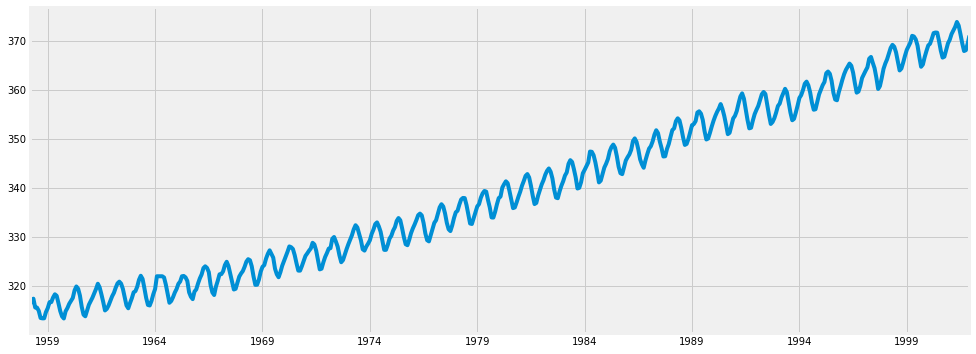

In [8]:
y.plot(figsize=(15, 6))

In [10]:
# parameters grid: ARGMIN AIC
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

warnings.filterwarnings("ignore") # specify to ignore warning messages
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.34362390202
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.7111727636625
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320035
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.2878503237043
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.6578978068096
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647912848518
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6881.0487556494045
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.6623277179715
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1379.1941067412524
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.4174716905945
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1115.5047735537973
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:780.4315920428842
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1119.5957893640186
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.0912987889553
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1240.221119919409
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:337.7938546075724
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:619.9501759055303
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:376.928376044414
A

In [15]:
# fit best params model 
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3182      0.092      3.442      0.001       0.137       0.499
ma.L1         -0.6254      0.077     -8.162      0.000      -0.776      -0.475
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8769      0.026    -33.811      0.000      -0.928      -0.826
sigma2         0.0972      0.004     22.632      0.000       0.089       0.106


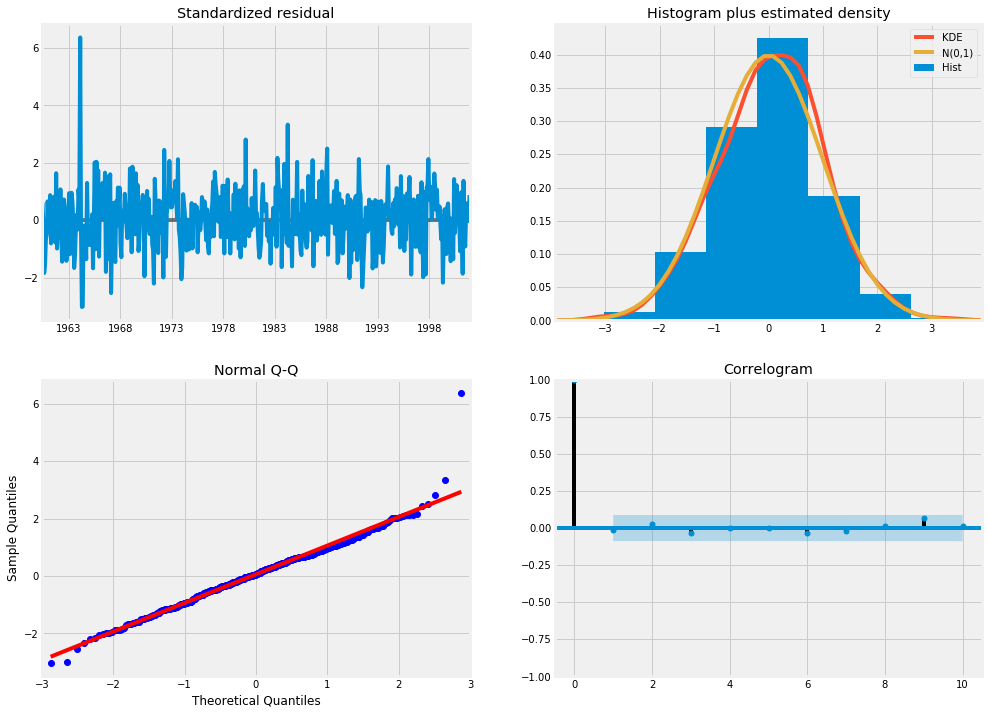

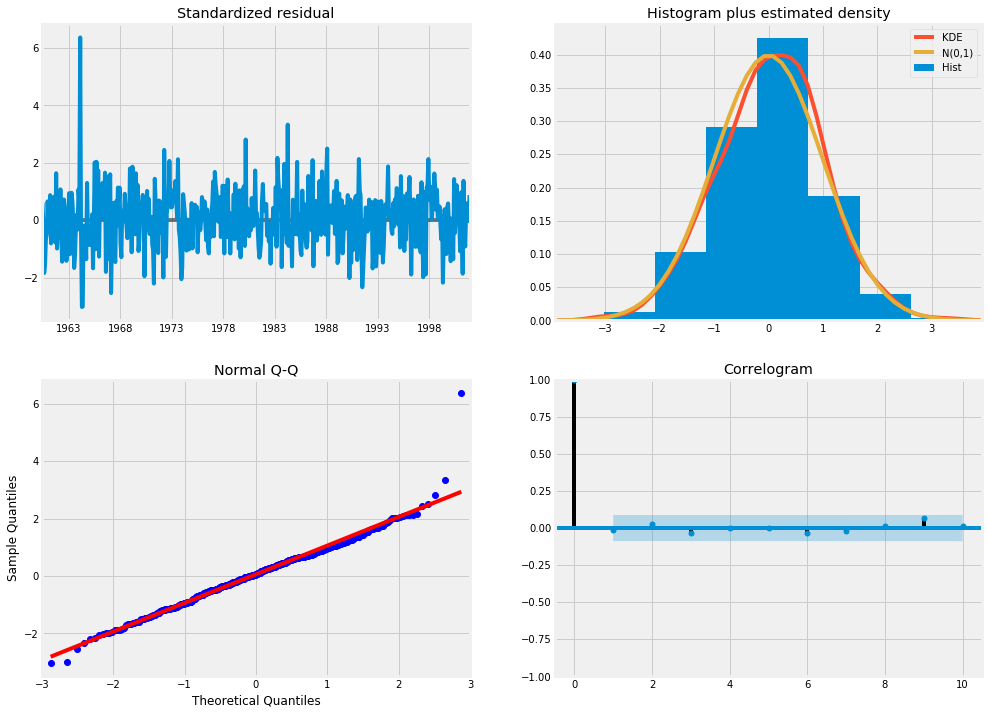

In [25]:
# diagnostics 
# top left - noise residuals
# hist + qqplot - noramal distibution
# correlogram - autocorrelation
results.plot_diagnostics(figsize=(15, 12))

The Mean Squared Error of our forecasts is 0.07


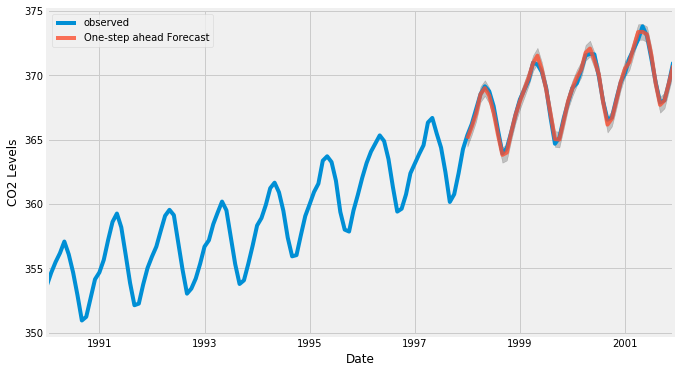

In [50]:
# check prediction
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)  # prediction
pred_ci = pred.conf_int()  # confint 

plt.figure(figsize=(10,6))
ax = y['1990':].plot(label='observed')  # plot pandas ts
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.8)  # add prediction

# add confint 
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

# Compute the mean square error
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

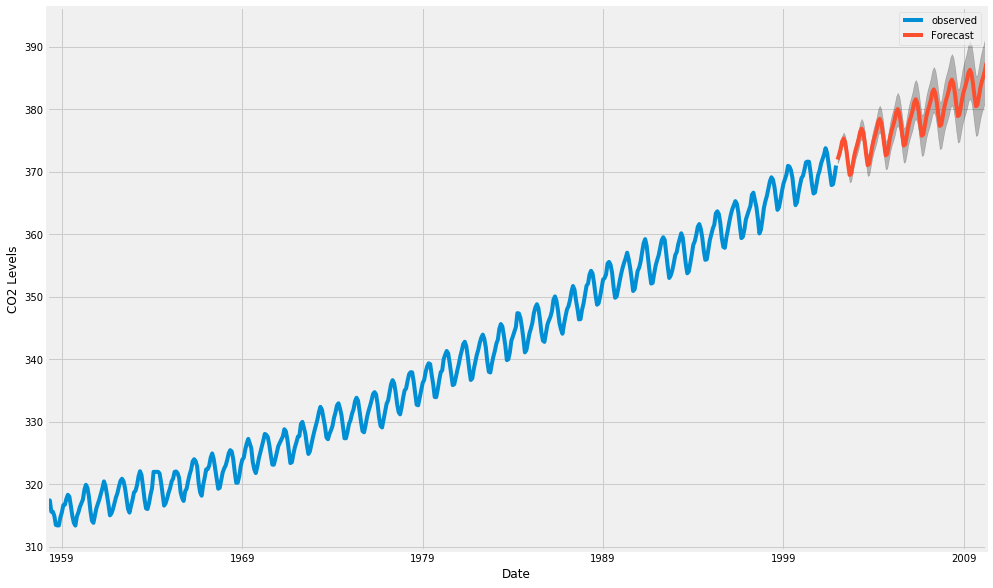

In [51]:
# forecast and visualize 
pred_uc = results.get_forecast(steps=100)  # 100 month forecast 
pred_ci = pred_uc.conf_int()  # confint 

ax = y.plot(label='observed', figsize=(15, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()